In [37]:
import warnings
warnings.filterwarnings('ignore')

In [38]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, TreeSearch, BDeuScore, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.independencies import IndependenceAssertion


df = pd.read_csv("CVD_cleaned.csv")
print(f'dfset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

dfset contains 308854 rows and 19 columns


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


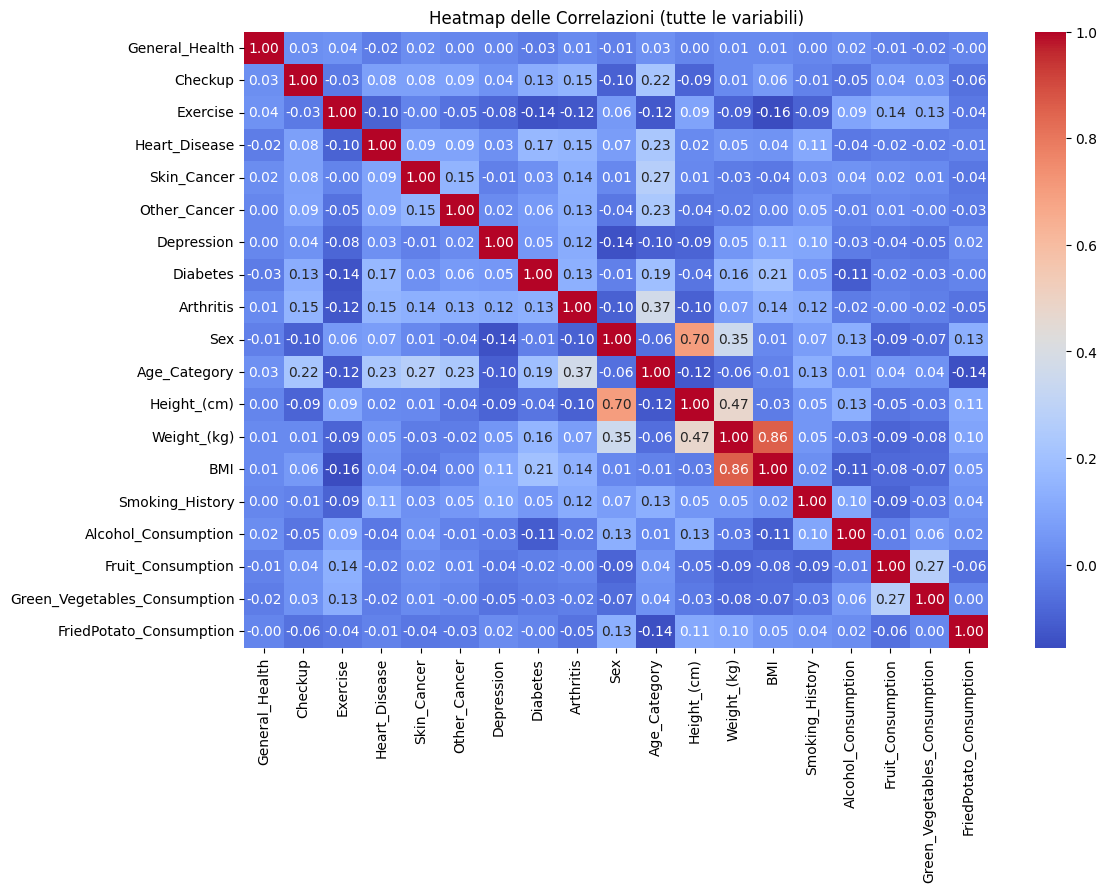

In [39]:
# Crea un dataframe temporaneo
df_temp = df.copy()

# Converte le variabili non numeriche in numeriche utilizzando il label encoding
for col in df_temp.select_dtypes(include=['object']).columns:
    df_temp[col] = df_temp[col].astype('category').cat.codes

# Calcola e visualizza la matrice di correlazione
plt.figure(figsize=(12, 8))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap delle Correlazioni (tutte le variabili)")
plt.show()

In [40]:
# Rimuovi le colonne 'General_Health' e 'Checkup'
df.drop(columns=['General_Health', 'Checkup'], inplace=True)

# Crea una nuova variabile 'Cancer'
df['Cancer'] = df.apply(lambda row: 'Yes' if row['Skin_Cancer'] == 'Yes' or row['Other_Cancer'] == 'Yes' else 'No', axis=1)

# Rimuovi le colonne 'Skin_Cancer' e 'Other_Cancer'
df.drop(columns=['Skin_Cancer', 'Other_Cancer'], inplace=True)

print(len(df.columns))
df.columns

16


Index(['Exercise', 'Heart_Disease', 'Depression', 'Diabetes', 'Arthritis',
       'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI',
       'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'Cancer'],
      dtype='object')

In [41]:
# cols_to_discretize = [
#     'Height_(cm)',
#     'Weight_(kg)',
#     'BMI',
#     'Alcohol_Consumption',
#     'Fruit_Consumption',
#     'Green_Vegetables_Consumption',
#     'FriedPotato_Consumption',
# ]

# for col in cols_to_discretize:
#     plt.figure(figsize=(12, 6))
#     ax = sns.countplot(x=df[col])
#     ticks = ax.get_xticks()
#     ax.set_xticks(ticks[::40])
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.show()

In [42]:
from sklearn.preprocessing import KBinsDiscretizer
colonne = ['Height_(cm)', 'Weight_(kg)', 'BMI']

# Inizializza il discretizzatore
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

# Applica la discretizzazione
df_disc = df.copy()
df_disc[colonne] = discretizer.fit_transform(df[colonne])



# Discretize 'Alcohol_Consumption'
df_disc['Alcohol_Consumption'] = pd.cut(
    df['Alcohol_Consumption'], bins=[-float('inf'), 2.0, float('inf')], labels=['Low', 'High']
)

# Discretize 'Fruit_Consumption'
df_disc['Fruit_Consumption'] = pd.cut(
    df['Fruit_Consumption'], bins=[-float('inf'), 15.0, float('inf')], labels=['Low', 'High']
)

# Discretize 'Green_Vegetables_Consumption'
df_disc['Green_Vegetables_Consumption'] = pd.cut(
    df['Green_Vegetables_Consumption'], bins=[-float('inf'), 16.0, float('inf')], labels=['Low', 'High']
)

# Discretize 'FriedPotato_Consumption'
df_disc['FriedPotato_Consumption'] = pd.cut(
    df['FriedPotato_Consumption'], bins=[-float('inf'), 10.0, float('inf')], labels=['Low', 'High']
)



In [55]:
# Stampa la distribuzione delle colonne discretizzate
discretized_columns = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

for col in discretized_columns:
    print(f"Distribuzione per la colonna '{col}':")
    print(df_disc[col].value_counts())
    print("\n")

Distribuzione per la colonna 'Height_(cm)':
Height_(cm)
3.0    96973
1.0    76605
2.0    70514
0.0    64762
Name: count, dtype: int64


Distribuzione per la colonna 'Weight_(kg)':
Weight_(kg)
1.0    83550
3.0    80225
2.0    76182
0.0    68897
Name: count, dtype: int64


Distribuzione per la colonna 'BMI':
BMI
3.0    78376
2.0    78364
1.0    76076
0.0    76038
Name: count, dtype: int64


Distribuzione per la colonna 'Alcohol_Consumption':
Alcohol_Consumption
Low     184985
High    123869
Name: count, dtype: int64


Distribuzione per la colonna 'Fruit_Consumption':
Fruit_Consumption
High    203710
Low     105144
Name: count, dtype: int64


Distribuzione per la colonna 'Green_Vegetables_Consumption':
Green_Vegetables_Consumption
Low     214976
High     93878
Name: count, dtype: int64


Distribuzione per la colonna 'FriedPotato_Consumption':
FriedPotato_Consumption
Low     254460
High     54394
Name: count, dtype: int64




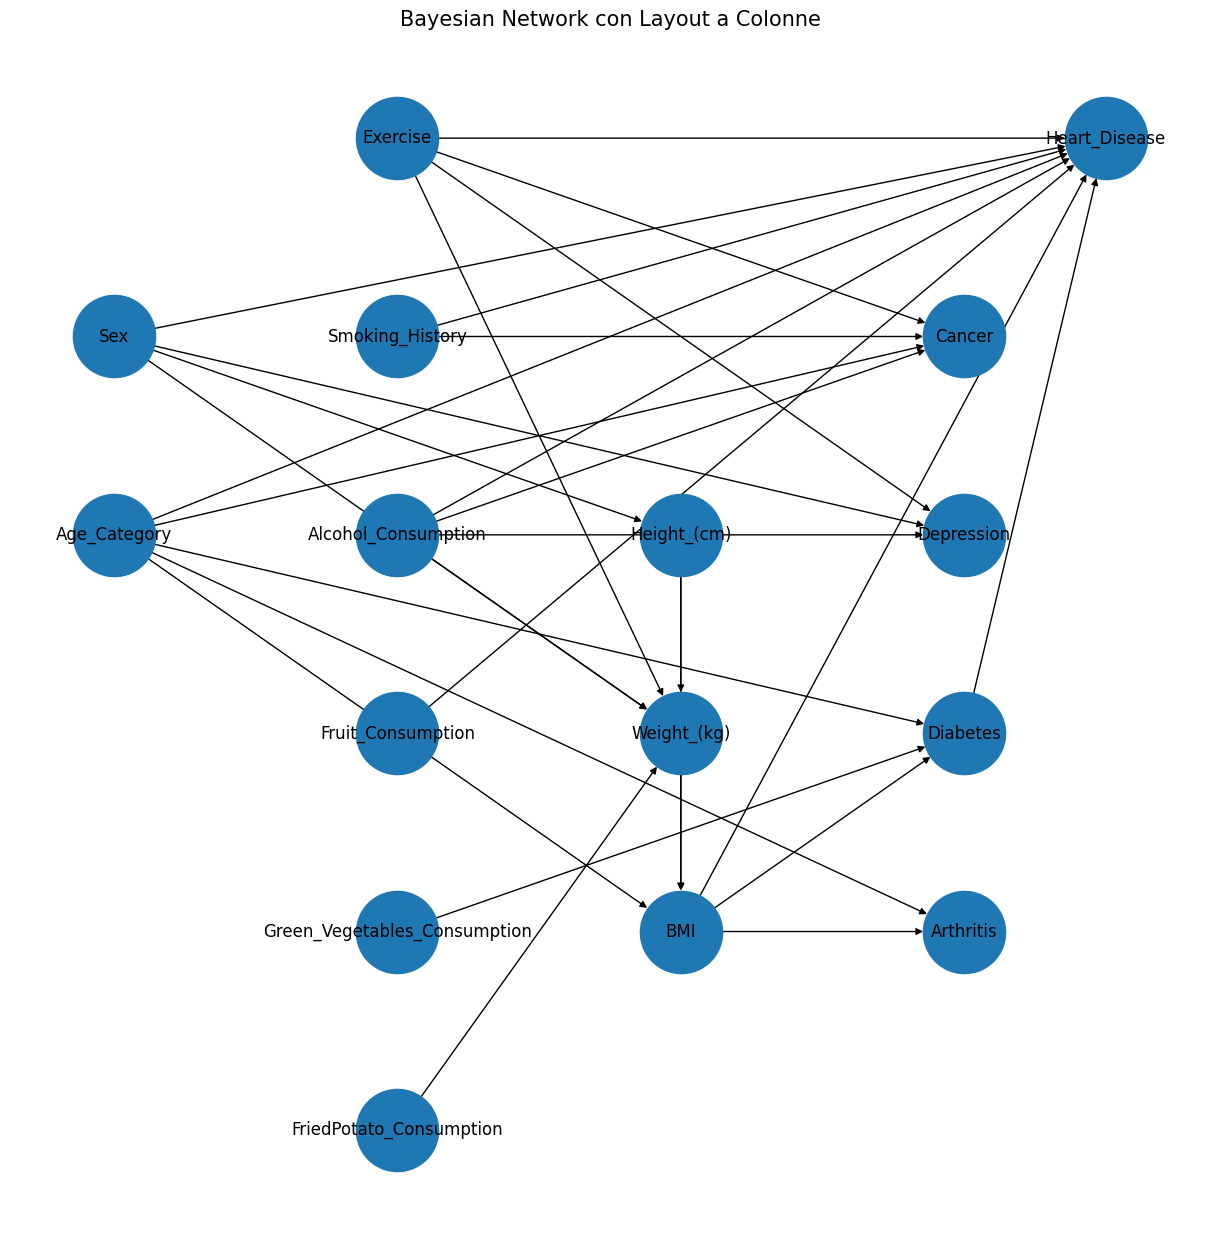

In [44]:
custom_model = BayesianModel([
    ('Height_(cm)', 'Weight_(kg)'),
    ('Height_(cm)', 'BMI'),
    ('Weight_(kg)', 'BMI'),

    ('Sex', 'Heart_Disease'),
    ('Sex', 'Depression'),
    ('Sex', 'Weight_(kg)'),
    ('Sex', 'Height_(cm)'),
    ('Age_Category', 'Heart_Disease'),
    ('Age_Category', 'Diabetes'),
    ('Age_Category', 'Arthritis'),
    ('Age_Category', 'BMI'),
    ('Age_Category', 'Cancer'),

    ('Smoking_History', 'Heart_Disease'),
    ('Smoking_History', 'Cancer'),

    ('Alcohol_Consumption', 'Heart_Disease'),
    ('Alcohol_Consumption', 'Cancer'),
    ('Alcohol_Consumption', 'Depression'),
    ('Alcohol_Consumption', 'Weight_(kg)'),
    ('Fruit_Consumption', 'Heart_Disease'),
    ('Green_Vegetables_Consumption', 'Diabetes'),
    ('FriedPotato_Consumption', 'Weight_(kg)'),
    ('Exercise', 'Heart_Disease'),
    ('Exercise', 'Depression'),
    ('Exercise', 'Weight_(kg)'),
    ('Exercise', 'Cancer'),

    ('BMI', 'Heart_Disease'),
    ('BMI', 'Diabetes'),
    ('BMI', 'Arthritis'),

    ('Diabetes', 'Heart_Disease'),
])



pos = {
    # Colonna 1: Fattori di base
    'Sex': (0, 3),
    'Age_Category': (0, 2),

    # Colonna 2: Stile di vita e dieta
    'Exercise': (2, 4),
    'Smoking_History': (2, 3),
    'Alcohol_Consumption': (2, 2),
    'Fruit_Consumption': (2, 1),
    'Green_Vegetables_Consumption': (2, 0),
    'FriedPotato_Consumption': (2, -1),

    # Colonna 3: Misure fisiche
    'Height_(cm)': (4, 2),
    'Weight_(kg)': (4, 1),
    'BMI': (4, 0),

    # Colonna 4: Condizioni mediche
    'Heart_Disease': (7, 4),
    'Cancer': (6, 3),
    'Depression': (6, 2),
    'Diabetes': (6, 1),
    'Arthritis': (6, 0),
}

# Disegno del grafo
plt.figure(figsize=(12, 12))
G = nx.DiGraph(custom_model.edges())
nx.draw(G, pos, with_labels=True, node_size=3500)

plt.title("Bayesian Network con Layout a Colonne", fontsize=15)
plt.axis("off")
plt.show()


Building tree: 100%|██████████| 120/120.0 [00:03<00:00, 33.43it/s]


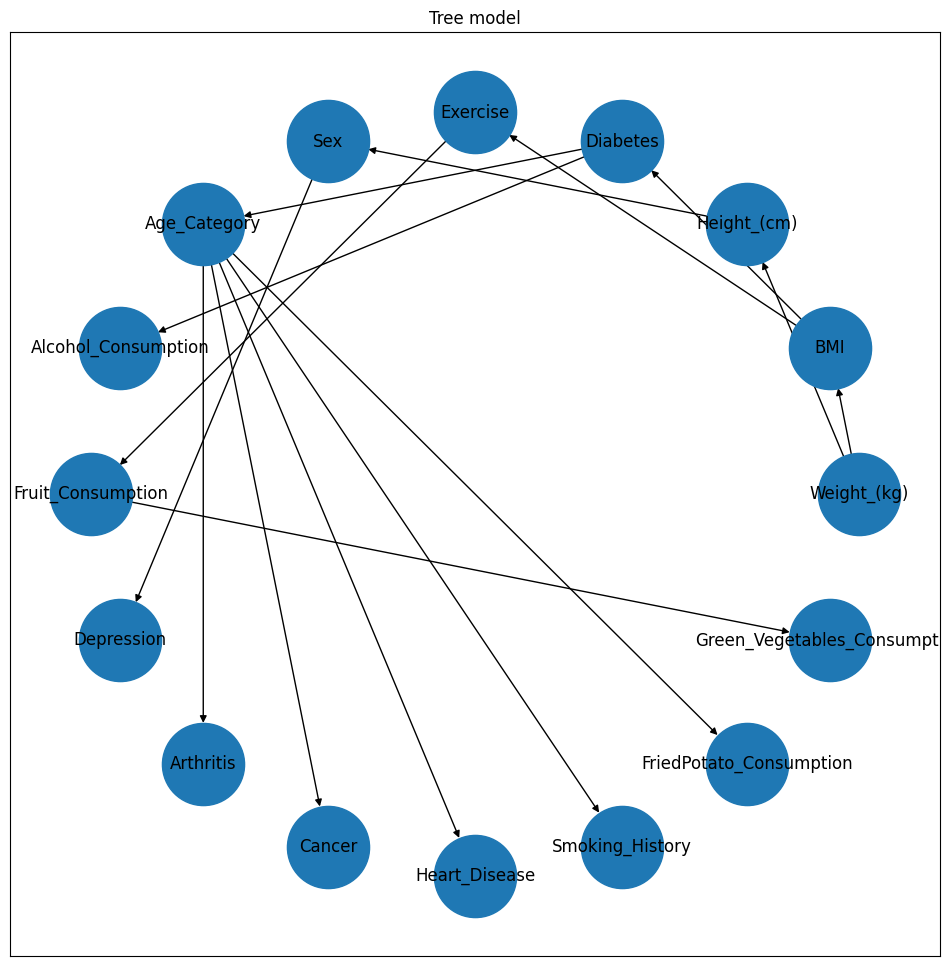

In [45]:
# ts = TreeSearch(data=df_disc, root_node='State')
ts = TreeSearch(data=df_disc)
tree_model = ts.estimate()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=3500)
# fig.savefig('tree')
ax.set_title('Tree model')
tree_model = BayesianModel(tree_model.edges())

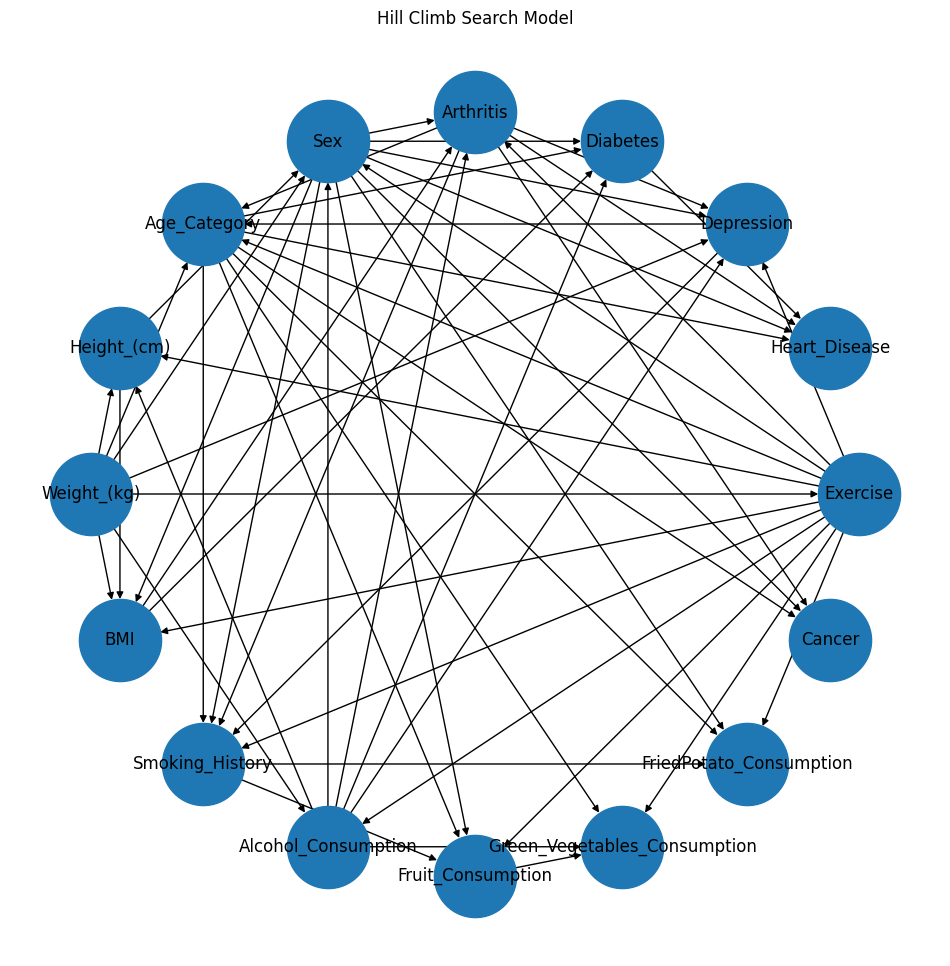

In [46]:
scorer = BDeuScore(data=df_disc)

hc = HillClimbSearch(data=df_disc)

hc_model = hc.estimate(scoring_method=scorer, show_progress=False)

plt.figure(figsize=(12, 12))
pos_hc = nx.drawing.layout.circular_layout(hc_model)
nx.draw_networkx(hc_model, pos=pos_hc, node_size=3500, with_labels=True, arrows=True)
plt.title('Hill Climb Search Model')
plt.axis('off')
plt.show()

hc_model_bayes = BayesianModel(hc_model.edges())

In [47]:
models = [('custom', custom_model), ('tree', tree_model), ('hc', hc_model_bayes)]
for name, model in models:
    print(f'Computing CPDs for {name} model')
    model.fit(df_disc, estimator=MaximumLikelihoodEstimator)

Computing CPDs for custom model
Computing CPDs for tree model
Computing CPDs for hc model


# Questions

In [48]:
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt

# Create inference objects for both models
infer_custom = VariableElimination(custom_model)
infer_tree = VariableElimination(tree_model)
infer_hc = VariableElimination(hc_model_bayes)


## Query 1:
"What's the probability of developing a cardiac disease given that the patient is non smoker and athletic?"

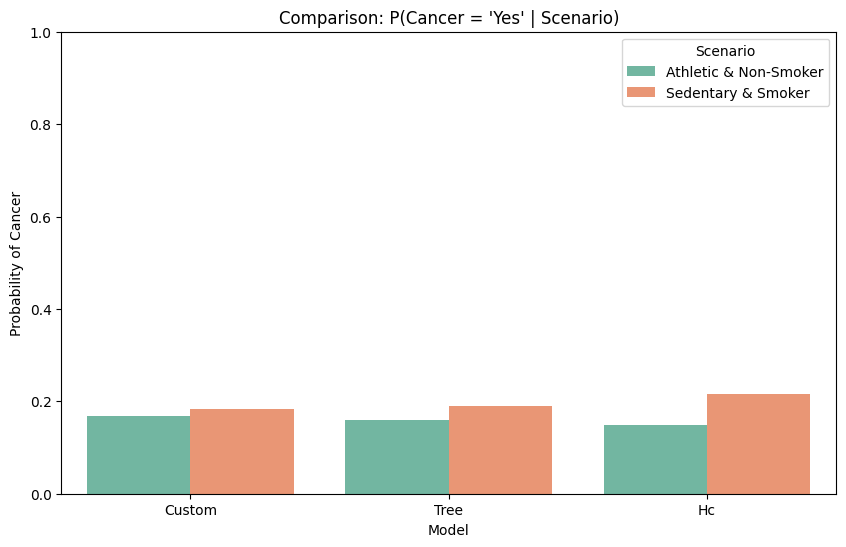

In [53]:
# Definition of scenarios to compare
scenarios = {
    "Athletic & Non-Smoker": {'Smoking_History': 'No', 'Exercise': 'Yes'},
    "Sedentary & Smoker": {'Smoking_History': 'Yes', 'Exercise': 'No'}
}

# List of models
models = {
    'Custom': infer_custom,
    'Tree': infer_tree,
    'Hc': infer_hc
}

# Perform queries and collect results
data = []
for scenario_label, evidence in scenarios.items():
    for model_label, model in models.items():
        result = model.query(variables=['Cancer'], evidence=evidence)
        try:
            states = result.state_names['Cancer']
        except (AttributeError, KeyError):
            states = ['No', 'Yes']
        for state, prob in zip(states, result.values):
            data.append({
                'Scenario': scenario_label,
                'Model': model_label,
                'Cancer': state,
                'Probability': prob
            })

# Create a DataFrame for visualization
df_plot = pd.DataFrame(data)

# Filter only the probability of Cancer = 'Yes'
df_yes = df_plot[df_plot['Cancer'] == 'Yes']

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=df_yes, x='Model', y='Probability', hue='Scenario', ci=None, palette="Set2", dodge=True)
plt.title("Comparison: P(Cancer = 'Yes' | Scenario)")
plt.ylim(0, 1)
plt.ylabel("Probability of Cancer")
plt.show()

## Query 2:
"What is the combined effect of factors such as alcohol consumption, diet (fruit, vegetables, and fried potatoes) and physical activity on the probability of developing hearth deseases?"

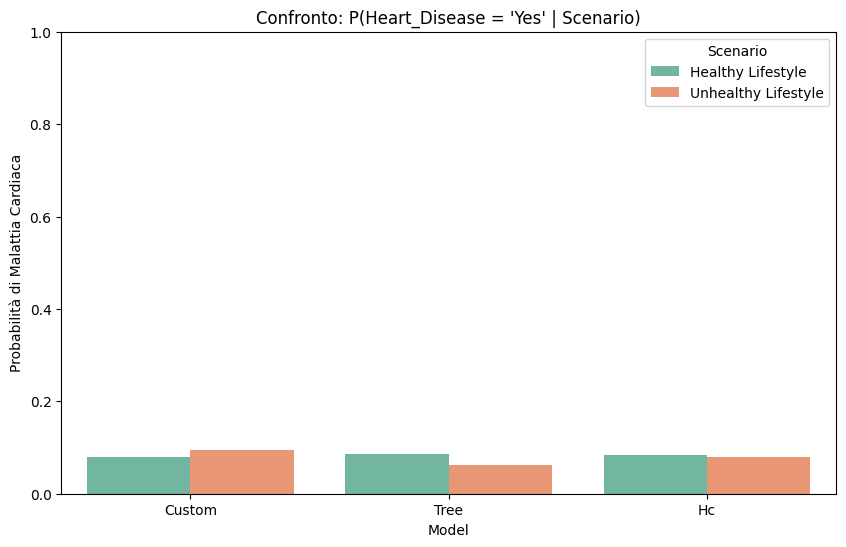

In [54]:
def new_func():
    # Definizione degli scenari da confrontare
    scenarios_heart_disease = {
        "Healthy Lifestyle": {
            'Exercise': 'Yes',
            'Alcohol_Consumption': 'Low',
            'Fruit_Consumption': 'High',
            'Green_Vegetables_Consumption': 'High',
            'FriedPotato_Consumption': 'Low'
        },
        "Unhealthy Lifestyle": {
            'Exercise': 'No',
            'Alcohol_Consumption': 'High',
            'Fruit_Consumption': 'Low',
            'Green_Vegetables_Consumption': 'Low',
            'FriedPotato_Consumption': 'High'
        }
    }

    # Eseguo le query per ciascun modello e raccolgo i risultati
    data_heart_disease = []
    for scenario_label, evidence in scenarios_heart_disease.items():
        for model_label, model in models.items():
            result = model.query(variables=['Heart_Disease'], evidence=evidence)
            try:
                states = result.state_names['Heart_Disease']
            except (AttributeError, KeyError):
                states = ['No', 'Yes']
            for state, prob in zip(states, result.values):
                data_heart_disease.append({
                    'Scenario': scenario_label,
                    'Model': model_label,
                    'Heart_Disease': state,
                    'Probability': prob
                })

    # Creo un DataFrame per la visualizzazione
    df_heart_disease_plot = pd.DataFrame(data_heart_disease)

    # Filtra solo la probabilità di Heart_Disease = 'Yes'
    df_heart_disease_yes = df_heart_disease_plot[df_heart_disease_plot['Heart_Disease'] == 'Yes']

    # Tracciamento del grafico a barre raggruppate
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_heart_disease_yes, x='Model', y='Probability', hue='Scenario', ci=None, palette="Set2", dodge=True)
    plt.title("Confronto: P(Heart_Disease = 'Yes' | Scenario)")
    plt.ylim(0, 1)
    plt.ylabel("Probabilità di Malattia Cardiaca")
    plt.show()

new_func()

Ecco alcune query interessanti per un modello bayesiano che sfrutta le colonne del dataset:

Influenza dell'esercizio e della storia del fumo sulla salute cardiaca:

Qual è la probabilità di sviluppare malattie cardiache dato un alto livello di esercizio fisico e una storia negativa di fumo?

Relazione tra dieta e rischio di diabete:

In che modo il consumo di frutta, verdure (in particolare quelle verdi) e patate fritte influenza la probabilità di sviluppare il diabete?

Interazione tra BMI, età e malattie croniche:

Dato il BMI, l'altezza, il peso e la categoria d'età, qual è la probabilità condizionata di avere il diabete o altre malattie croniche come l'artrite?

Effetto combinato degli stili di vita sul cancro:

Qual è l'effetto combinato di fattori quali consumo di alcol, dieta (frutta, verdure e patate fritte) e attività fisica sulla probabilità di sviluppare il cancro?

Relazione tra depressione e fattori demografici:

Come influiscono sesso, categoria d'età e stile di vita (esercizio fisico, storia di fumo e consumo di alcol) sulla probabilità di sviluppare la depressione?

Interazioni multiple per la salute complessiva:

Qual è la probabilità che un individuo presenti più condizioni (ad esempio, malattie cardiache, diabete e artrite) in base a un insieme di fattori come BMI, dieta, attività fisica e storia di fumo?

Confronto tra effetti diretti e indiretti:

Quanto incide direttamente il consumo di alcol e indirettamente il livello di esercizio fisico sul rischio di cancro, controllando per variabili demografiche (sesso, età)?

Relazione tra fattori fisici e comportamentali:

In che modo le variabili misurate (altezza, peso, BMI) interagiscono con comportamenti (esercizio, dieta, fumo) per influenzare il rischio di malattie come il diabete e le malattie cardiache?